### Implementation of PRML book.
Repo: https://github.com/ctgk/PRML

In [23]:
# source: https://github.com/ctgk/PRML/blob/master/prml/feature_extractions/pca.py

import numpy as np

class PCA(object):

    def __init__(self, n_components):
        """
        construct principal component analysis

        Parameters
        ----------
        n_components : int
            number of components
        """
        assert isinstance(n_components, int)
        self.n_components = n_components

    def fit(self, X, method="eigen", iter_max=100):
        """
        maximum likelihood estimate of pca parameters
        x ~ \int_z N(x|Wz+mu,sigma^2)N(z|0,I)dz

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data
        method : str
            method to estimate the parameters
            ["eigen", "em"]
        iter_max : int
            maximum number of iterations for em algorithm

        Attributes
        ----------
        mean : (n_features,) ndarray
            sample mean of the data
        W : (n_features, n_components) ndarray
            projection matrix
        var : float
            variance of observation noise
        C : (n_features, n_features) ndarray
            variance of the marginal dist N(x|mean,C)
        Cinv : (n_features, n_features) ndarray
            precision of the marginal dist N(x|mean, C)
        """
        method_list = ["eigen", "em"]
        if method not in method_list:
            print("availabel methods are {}".format(method_list))
        self.mean = np.mean(X, axis=0)
        getattr(self, method)(X - self.mean, iter_max)

    def eigen(self, X, *arg):
        sample_size, n_features = X.shape
        if sample_size >= n_features:
            cov = np.cov(X, rowvar=False)
            values, vectors = np.linalg.eigh(cov)
            index = n_features - self.n_components
        else:
            cov = np.cov(X)
            values, vectors = np.linalg.eigh(cov)
            vectors = (X.T @ vectors) / np.sqrt(sample_size * values)
            index = sample_size - self.n_components
        self.I = np.eye(self.n_components)
        if index == 0:
            self.var = 0
        else:
            self.var = np.mean(values[:index])

        self.W = vectors[:, index:].dot(np.sqrt(np.diag(values[index:]) - self.var * self.I))
        self.__M = self.W.T @ self.W + self.var * self.I
        self.C = self.W @ self.W.T + self.var * np.eye(n_features)
        if index == 0:
            self.Cinv = np.linalg.inv(self.C)
        else:
            self.Cinv = np.eye(n_features) / np.sqrt(self.var) - self.W @ np.linalg.inv(self.__M) @ self.W.T / self.var

    def em(self, X, iter_max):
        self.I = np.eye(self.n_components)
        self.W = np.eye(np.size(X, 1), self.n_components)
        self.var = 1.
        for i in range(iter_max):
            W = np.copy(self.W)
            stats = self._expectation(X)
            self._maximization(X, *stats)
            if np.allclose(W, self.W):
                print('Finish after {} iterations'.format(i))
                break
        self.C = self.W @ self.W.T + self.var * np.eye(np.size(X, 1))
        self.Cinv = np.linalg.inv(self.C)

    def _expectation(self, X):
        self.__M = self.W.T @ self.W + self.var * self.I
        Minv = np.linalg.inv(self.__M)
        Ez = X @ self.W @ Minv
        Ezz = self.var * Minv + Ez[:, :, None] * Ez[:, None, :]
        return Ez, Ezz

    def _maximization(self, X, Ez, Ezz):
        self.W = X.T @ Ez @ np.linalg.inv(np.sum(Ezz, axis=0))
        self.var = np.mean(
            np.mean(X ** 2, axis=1)
            - 2 * np.mean(Ez @ self.W.T * X, axis=1)
            + np.trace((Ezz @ self.W.T @ self.W).T) / np.size(X, 1))

    def transform(self, X):
        """
        project input data into latent space
        p(Z|X) = N(Z|(X-mu)WMinv, sigma^-2M)

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        Z : (sample_size, n_components) ndarray
            projected input data
        """
        return np.linalg.solve(self.__M, ((X - self.mean) @ self.W).T).T

    def fit_transform(self, X, method="eigen"):
        """
        perform pca and whiten the input data

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        Z : (sample_size, n_components) ndarray
            projected input data
        """
        self.fit(X, method)
        return self.transform(X)

    def proba(self, X):
        """
        the marginal distribution of the observed variable

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        p : (sample_size,) ndarray
            value of the marginal distribution
        """
        d = X - self.mean
        return (
            np.exp(-0.5 * np.sum(d @ self.Cinv * d, axis=-1))
            / np.sqrt(np.linalg.det(self.C))
            / np.power(2 * np.pi, 0.5 * np.size(X, 1)))

In [24]:
# source: https://github.com/ctgk/PRML/blob/master/prml/feature_extractions/bayesian_pca.py

class BayesianPCA(PCA):

    def fit(self, X, iter_max=100, initial="random"):
        """
        empirical bayes estimation of pca parameters
        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data
        iter_max : int
            maximum number of em steps
        Returns
        -------
        mean : (n_features,) ndarray
            sample mean fo the input data
        W : (n_features, n_components) ndarray
            projection matrix
        var : float
            variance of observation noise
        """
        initial_list = ["random", "eigen"]
        self.mean = np.mean(X, axis=0)
        self.I = np.eye(self.n_components)
        if initial not in initial_list:
            print("availabel initializations are {}".format(initial_list))
        if initial == "random":
            self.W = np.eye(np.size(X, 1), self.n_components)
            self.var = 1.
        elif initial == "eigen":
            self.eigen(X)
        self.alpha = len(self.mean) / np.sum(self.W ** 2, axis=0).clip(min=1e-10)
        for i in range(iter_max):
            W = np.copy(self.W)
            stats = self._expectation(X - self.mean)
            self._maximization(X - self.mean, *stats)
            self.alpha = len(self.mean) / np.sum(self.W ** 2, axis=0).clip(min=1e-10)
            if np.allclose(W, self.W):
                print('Finish after {} iterations'.format(i))
                break
        self.n_iter = i + 1

    def _maximization(self, X, Ez, Ezz):
        self.W = X.T @ Ez @ np.linalg.inv(np.sum(Ezz, axis=0) + self.var * np.diag(self.alpha))
        self.var = np.mean(
            np.mean(X ** 2, axis=-1)
            - 2 * np.mean(Ez @ self.W.T * X, axis=-1)
            + np.trace((Ezz @ self.W.T @ self.W).T) / len(self.mean))

    def maximize(self, D, Ez, Ezz):
        self.W = D.T.dot(Ez).dot(np.linalg.inv(np.sum(Ezz, axis=0) + self.var * np.diag(self.alpha)))
        self.var = np.mean(
            np.mean(D ** 2, axis=-1)
            - 2 * np.mean(Ez.dot(self.W.T) * D, axis=-1)
            + np.trace(Ezz.dot(self.W.T).dot(self.W).T) / self.ndim)

In [25]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits
%matplotlib inline

In [26]:
np.random.seed(1024)

In [91]:
# dataset = load_iris()
dataset = load_digits()
X, y = dataset.data, dataset.target
X = StandardScaler().fit_transform(X)

In [27]:
from observations import iris, mnist
DATA_DIR = './data'

In [28]:
selected_classes = [0,1]
num_datapoints = 5000
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
    mask = [True if yclass in selected_classes else False for yclass in y_train]
    x_train = x_train[mask][:num_datapoints]
    y_class = y_train[mask][:num_datapoints]
    return x_train, y_class

X, y = load_mnist()

Finish after 1 iterations


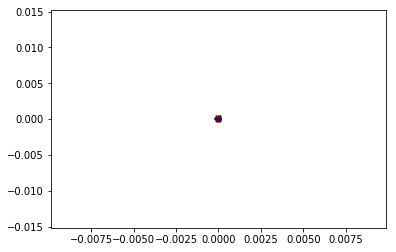

In [29]:
pca = PCA(n_components=2)
pca.fit(X, method="em", iter_max=int(1e2)) #["em", "eigen"]
X2d = pca.transform(X)
plt.scatter(X2d[:,0], X2d[:,1], c=y)
plt.show()

Finish after 1 iterations


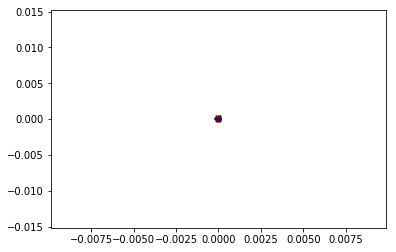

In [31]:
bpca = BayesianPCA(n_components=2)
bpca.fit(X, iter_max=int(1e2), initial="random") #["random", "eigen"]
X2d = bpca.transform(X)
plt.scatter(X2d[:,0], X2d[:,1], c=y)
plt.show()